<a href="https://colab.research.google.com/github/hishamp3/Thesis-NLP/blob/main/Y_N_tokenizer_approach3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Transformers
!pip install transformers==4.20.0
!pip install torch torchvision
!pip install pandas
!pip install numpy

In [ ]:
# loading data
import pandas as pd
train_data_df = pd.read_json(path_or_buf="./sample_data/train.jsonl", lines=True,orient='records')
dev_data_df = pd.read_json(path_or_buf="./sample_data/dev.jsonl", lines=True,orient='records')

In [ ]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu


In [ ]:
import transformers
from transformers import BloomForCausalLM
from transformers import BloomTokenizerFast
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import GPT2Tokenizer, GPT2Model
import torch

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#setting seeds
random.seed(26)
np.random.seed(26)
torch.manual_seed(26)

#tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
#model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-560m")

tokenizer = AutoTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('roberta-large')
#tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
#model = GPT2Model.from_pretrained('gpt2')

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

In [ ]:
model.to(device)
learning_rate = 1e-5
optimizer = AdamW(model.parameters(),lr=learning_rate,eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def encode_data(tokenizer, questions, passages, max_length):
    """Encode the question/passage pairs into features than can be fed to the model"""
    input_ids = []
    attention_masks = []

    for question,passage in zip(questions,passages):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True,truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids),np.array(attention_masks)

In [ ]:
passages_train = train_data_df.passage.values
questions_train = train_data_df.question.values
answers_train = train_data_df.answer.values.astype(int)

passages_dev = dev_data_df.passage.values
questions_dev = dev_data_df.question.values
answers_dev = dev_data_df.answer.values.astype(int)

In [ ]:
max_seq_length = 256
input_ids_train,attention_masks_train = encode_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev,attention_masks_dev = encode_data(tokenizer, questions_dev, passages_dev, max_seq_length)

train_features = (input_ids_train,attention_masks_train,answers_train)
dev_features = (input_ids_dev,attention_masks_dev,answers_dev)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# building dataloaders
batch_size = 8
train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)

In [ ]:
print()

In [ ]:
torch.cuda.empty_cache()
def cache_clear():
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
epochs =3
grad_acc_steps = 4
train_loss_values = []
dev_acc_values = []

for _ in tqdm(range(epochs), desc="Epoch"):

    #training
    epoch_train_loss = 0
    model.train()
    model.zero_grad()

    for step,batch in enumerate(train_dataloader):
        inputs_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)

        # cache_clear()
        outputs = model(inputs_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)
        #outputs = model(inputs_ids, attention_mask=attention_masks, labels=labels)

        loss = outputs[0]
        loss = loss / grad_acc_steps
        epoch_train_loss += loss.item()

        loss.backward()

        if(step+1) % grad_acc_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            optimizer.step()
            model.zero_grad()

    epoch_train_loss = epoch_train_loss / len(train_dataloader)
    train_loss_values.append(epoch_train_loss)

    #Evaluation
    epoch_dev_accuracy = 0
    model.eval()

    for batch in dev_dataloader:

        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2]

        with torch.no_grad():
            outputs = model(input_ids, token_type_ids=None, attention_mask = attention_masks)
            # outputs = model(inputs_ids, attention_mask=attention_masks, labels=labels)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()

        predictions = np.argmax(logits,axis=1).flatten()
        labels = labels.numpy().flatten()

        epoch_dev_accuracy += np.sum(predictions==labels)/len(labels)

    epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
    dev_acc_values.append(epoch_dev_accuracy)

Epoch: 100%|██████████| 3/3 [1:15:45<00:00, 1515.12s/it]


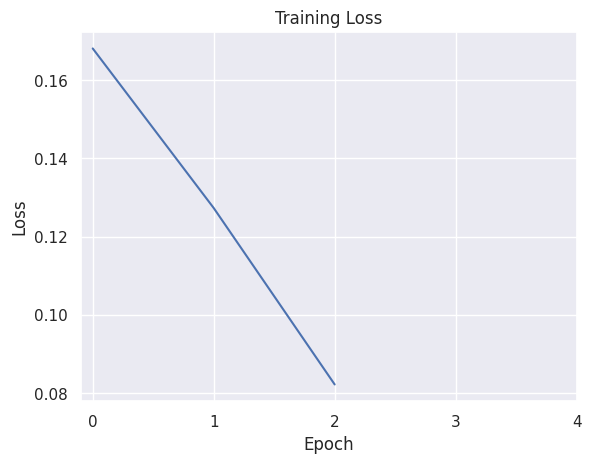

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
plt.plot(train_loss_values, label="train_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
# plt.Legend()
plt.xticks(np.arange(0,5))
plt.show()

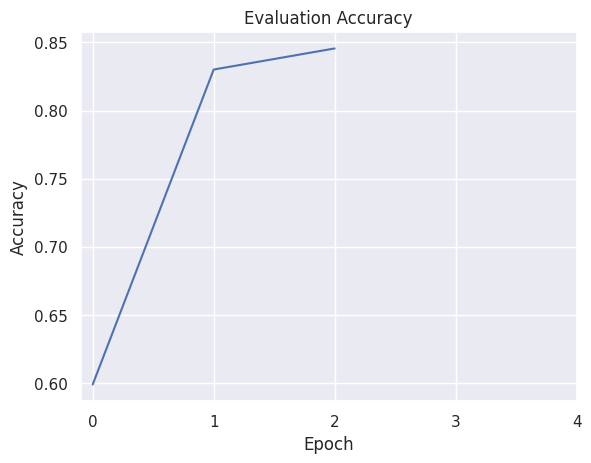

In [ ]:
plt.plot(dev_acc_values, label="dev_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
# plt.Legend()
plt.xticks(np.arange(0,5))
plt.show()

In [ ]:
print(dev_acc_values)

In [ ]:
def predict(question, passage):
  sequence = tokenizer.encode_plus(question, passage, return_tensors="pt")['input_ids'].to(device)

  logits = model(sequence)[0]
  probabilities = torch.softmax(logits, dim=1).detach().cpu().tolist()[0]
  proba_yes = round(probabilities[1], 2)
  proba_no = round(probabilities[0], 2)

  print(f"Question: {question}, Yes: {proba_yes}, No: {proba_no}")

passage_superbowl = """Super Bowl 50 was an American football game to determine the champion of the National Football League
                    (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated
                    the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title.
                    The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara,
                    California. As this was the 50th Super Bowl, the league emphasized the 'golden anniversary' with various
                    gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game
                    with Roman numerals (under which the game would have been known as 'Super Bowl L'), so that the logo could
                    prominently feature the Arabic numerals 50."""

passage_illuin = """Illuin designs and builds solutions tailored to your strategic needs using Artificial Intelligence
                  and the new means of human interaction this technology enables."""

passage_planets = '''A planet is a large, rounded astronomical body that is neither a star nor its remnant. The best available theory of planet formation is the nebular hypothesis, which posits that an interstellar cloud collapses out of a nebula to create a young protostar orbited by a protoplanetary disk. Planets grow in this disk by the gradual accumulation of material driven by gravity, a process called accretion. The Solar System has at least eight planets: the terrestrial planets Mercury, Venus, Earth and Mars, and the giant planets Jupiter, Saturn, Uranus and Neptune. These planets each rotate around an axis tilted with respect to its orbital pole. All planets of the Solar System other than Mercury possess a considerable atmosphere, and some share such features as ice caps, seasons, volcanism, hurricanes, tectonics, and even hydrology. Apart from Venus and Mars, the Solar System planets generate magnetic fields, and all except Venus and Mercury have natural satellites. The giant planets bear planetary rings, the most prominent being those of Saturn.'''
planets_questions = [
    "Mercury is a planet",
    "Planet is a star",
    "Mercury has a no atmosphere",
    "There are eight planets in solar system",
    "There are hundred planets in solar system",
    "Venus is closer to sun compared to mercury"

]

superbowl_questions = [
"the Super Bowl 50 was played in November",
"Did the Denver Broncos win the Super Bowl 50?",
"Did the Carolina Panthers win the Super Bowl 50?",
"Was the Super Bowl played at Levi's Stadium?",
"Was the Super Bowl 50 played in Las Vegas?",
"Was the Super Bowl 50 played in February?",
"Was the Super Bowl 50 played in March?"
]

question_illuin = "Is Illuin the answer to your strategic needs?"

In [ ]:
for s_question in planets_questions:
  predict(s_question, passage_planets)

Question: Mercury is a planet, Yes: 0.97, No: 0.03
Question: Planet is a star, Yes: 0.02, No: 0.98
Question: Mercury has a no atmosphere, Yes: 0.23, No: 0.77
Question: There are eight planets in solar system, Yes: 0.98, No: 0.02
Question: There are hundred planets in solar system, Yes: 0.15, No: 0.85
Question: Venus is closer to sun compared to mercury, Yes: 0.25, No: 0.75


In [ ]:
for s_question in superbowl_questions:
  predict(s_question, passage_superbowl)

predict(question_illuin, passage_illuin)

Question: the Super Bowl 50 was played in November, Yes: 0.17, No: 0.83
Question: Did the Denver Broncos win the Super Bowl 50?, Yes: 0.99, No: 0.01
Question: Did the Carolina Panthers win the Super Bowl 50?, Yes: 0.06, No: 0.94
Question: Was the Super Bowl played at Levi's Stadium?, Yes: 0.99, No: 0.01
Question: Was the Super Bowl 50 played in Las Vegas?, Yes: 0.02, No: 0.98
Question: Was the Super Bowl 50 played in February?, Yes: 0.98, No: 0.02
Question: Was the Super Bowl 50 played in March?, Yes: 0.09, No: 0.91
Question: Is Illuin the answer to your strategic needs?, Yes: 0.95, No: 0.05
